In [266]:
from sealrtc import *
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as opt
from scipy import signal
import tqdm
from sealrtc.controllers.identifier import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
ol_values = np.load(joindata("openloop", "ol_f_1_z_stamp_03_11_2021_13_58_53.npy"))
dmc2wf = np.load(joindata("bestflats", "lodmc2wfe.npy"))
ol_values *= dmc2wf

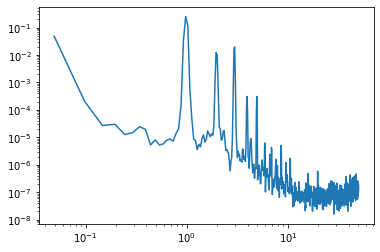

In [270]:
freqs, psd_tilt = genpsd(ol_values[:,0], dt=1/fs)
_, psd_tip = genpsd(ol_values[:,1], dt=1/fs)
plt.loglog(freqs, psd_tilt)

In [278]:
fcens = find_psd_peaks(freqs, psd_tilt)

In [317]:
f1 = fs / 120
f2 = fs / 3
mask = np.intersect1d(np.where(f1 <= freqs), np.where(freqs <= f2))
mask
reslin = stats.linregress(np.log(freqs[mask]), np.log(psd_tilt[mask]))
fitpower = np.e ** (reslin.slope * np.log(freqs) + reslin.intercept)
deviation = np.log(psd_tilt) - (reslin.slope * np.log(freqs) + reslin.intercept)
peak_mask = np.where(deviation > 3 * np.std(deviation))
modified_psd_tilt = copy(psd_tilt)
modified_psd_tilt[peak_mask] = fitpower[peak_mask]
reslin_mod = stats.linregress(np.log(freqs[mask]), np.log(modified_psd_tilt[mask]))
modified_fitpower = np.e ** (reslin_mod.slope * np.log(freqs) + reslin_mod.intercept)

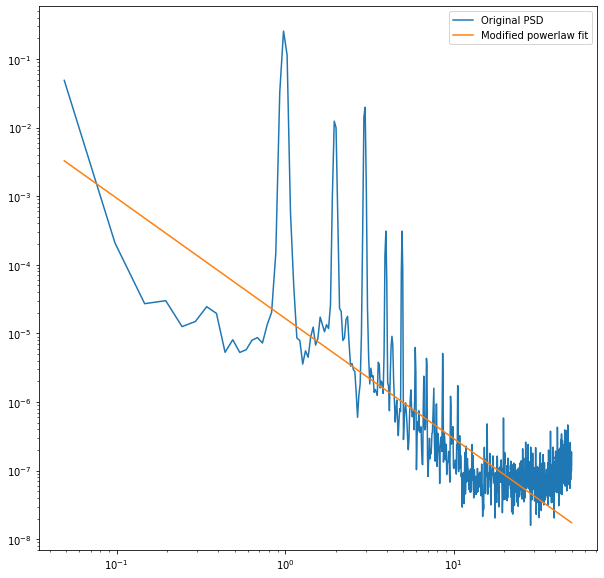

In [318]:
plt.figure(figsize=(10,10))
plt.loglog(freqs, psd_tilt, label="Original PSD")
#plt.loglog(freqs, fitpower, label="Powerlaw fit")
#plt.loglog(freqs, modified_psd_tilt, color='k', label="Cut-out peak values")
plt.loglog(freqs, modified_fitpower, label="Modified powerlaw fit")
plt.legend()

In [326]:
df

0.048828125

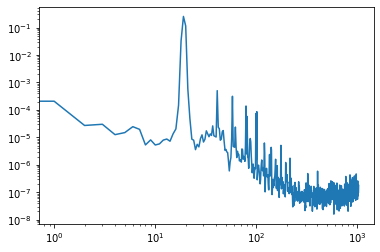

(1.0006975520160313, 0.0009837298998782269, 0.004027336666210651)


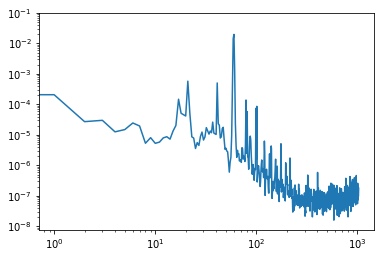

(2.95679408342985, 0.0009961374514235691, 0.004020892413029576)


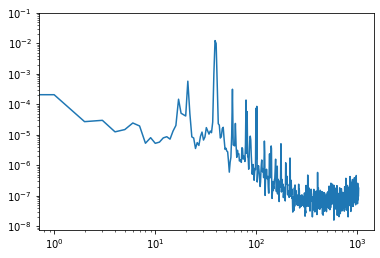

(1.9786126328481517, 9.48424167403236e-06, 0.004015756118978392)


In [333]:
for fpeak in find_psd_peaks(freqs, psd_tilt):
    one_peak_psd = copy(modified_psd_tilt)
    one_peak_mask = np.abs(freqs - fpeak) < 2 * df
    one_peak_psd[one_peak_mask] = psd_tilt[one_peak_mask] 
    print(fit_psd(freqs, one_peak_psd, fpeak))

In [343]:
fit_psd(freqs, psd_tilt, 1)

([0.9957819454206822], [0.000237243431235104], [0.0032127277264527563])